In [7]:
import os

os.system('pip install umap-learn')

import cv2
import numpy as np
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights


  Using cached umap_learn-0.5.11-py3-none-any.whl.metadata (26 kB)
  Using cached pynndescent-0.6.0-py3-none-any.whl.metadata (6.9 kB)
Using cached umap_learn-0.5.11-py3-none-any.whl (90 kB)
Using cached pynndescent-0.6.0-py3-none-any.whl (73 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [umap-learn]


2026-01-21 13:44:20.143852: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-21 13:44:20.342348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-21 13:44:22.371920: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [8]:
annotation_path = '/workspace/some_exp/genus/hald_assignment/StudyCase/_annotations.coco.json'
images_dir  = 'workspace/some_exp/genus/hald_assignment/StudyCase/images'



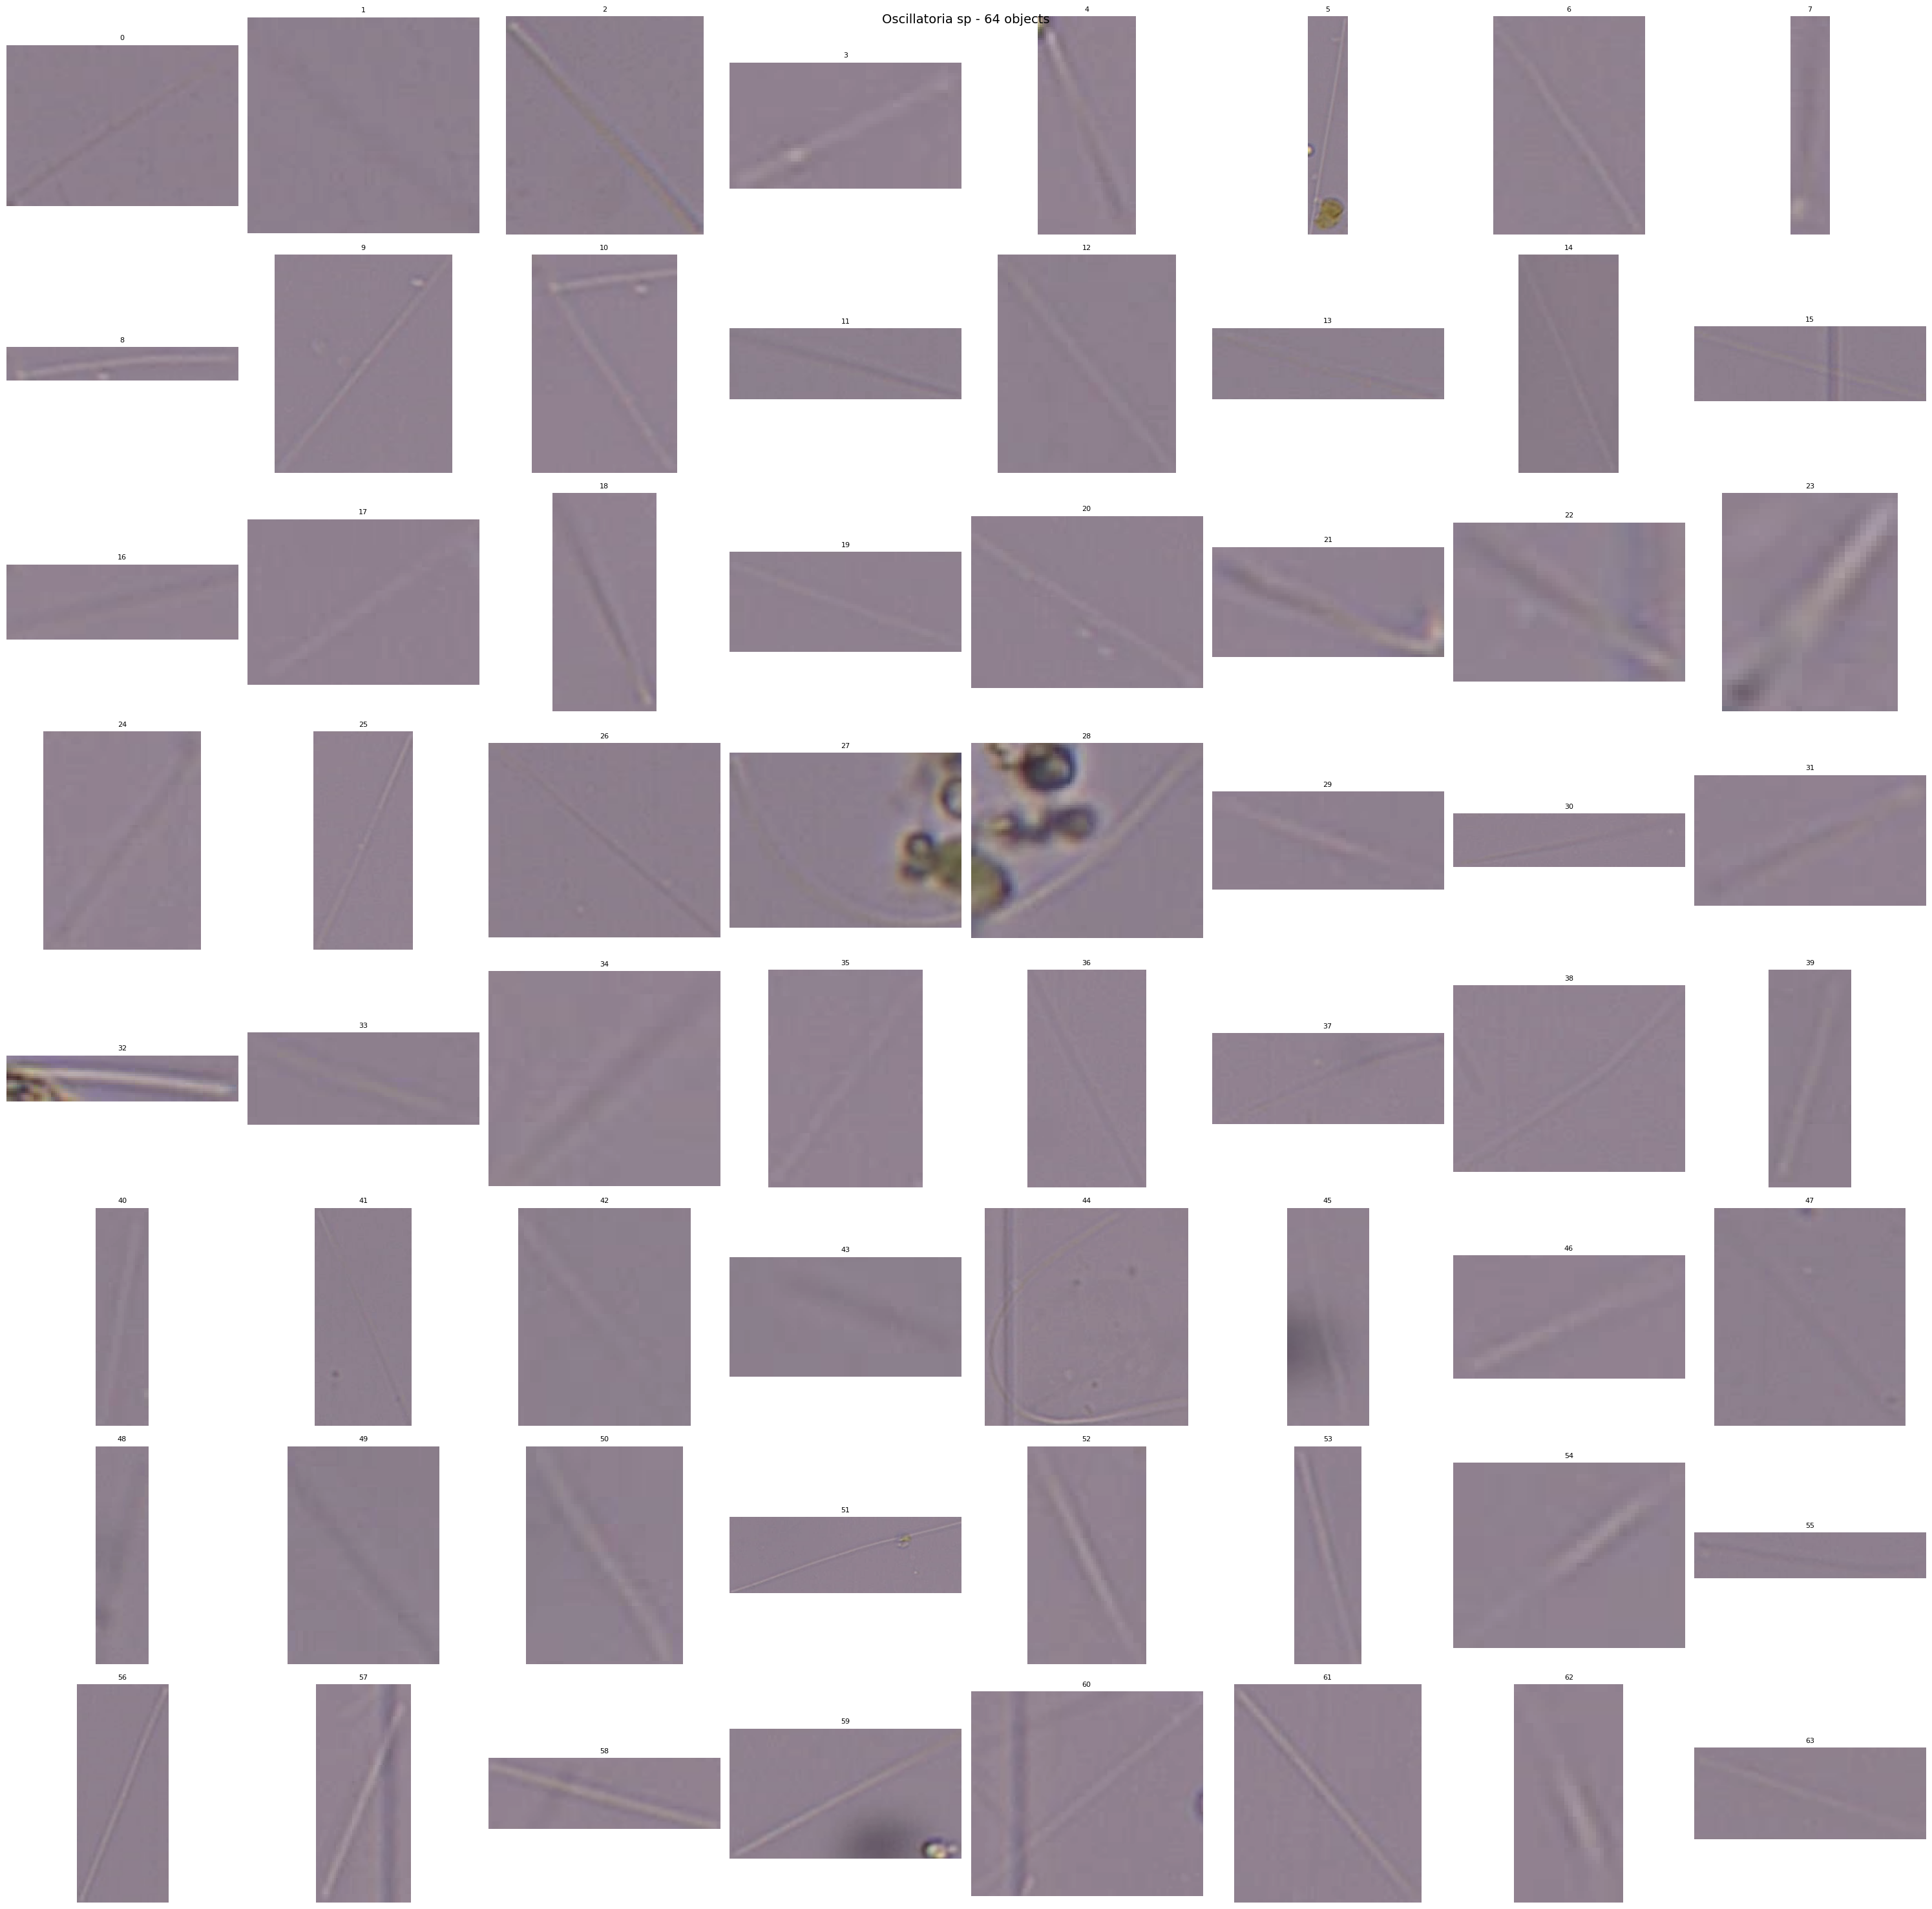

In [25]:
def load_coco_annotations(annotation_path: str) -> Dict:
  """Load COCO format annotations from JSON file"""
  with open(annotation_path, 'r') as f:
      return json.load(f)

def get_annotated_image_by_id(
      image_id: int,
      coco_data: Dict,
      images_dir: str
  ) -> np.ndarray:
      """Get image with bounding boxes and class labels drawn"""
      # Find image info
      image_info = next((img for img in coco_data['images'] if img['id'] == image_id), None)
      if not image_info:
          raise ValueError(f"Image ID {image_id} not found")

      # Load image
      img_path = f"{images_dir}/{image_info['file_name']}"
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      # Get annotations for this image
      annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

      # Create category mapping
      categories = {cat['id']: cat['name'] for cat in coco_data['categories']}

      # Draw annotations
      for ann in annotations:
          bbox = ann['bbox']  # [x, y, width, height]
          x, y, w, h = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])

          # Draw rectangle
          cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

          # Add label
          label = categories[ann['category_id']]
          cv2.putText(img, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                     0.5, (255, 255, 255), 1)

      return img

def extract_objects_by_class(
  class_name: str,
  coco_data: Dict,
  images_dir: str,
  max_objects: int = 100
) -> List[np.ndarray]:
  """Extract cropped objects for a specific class"""
  # Find category ID
  category_id = next((cat['id'] for cat in coco_data['categories']
                     if cat['name'] == class_name), None)

  # Get all annotations for this class
  class_annotations = [ann for ann in coco_data['annotations']
                       if ann['category_id'] == category_id][:max_objects]

  # Create image ID to info mapping
  image_map = {img['id']: img for img in coco_data['images']}

  extracted_objects = []

  for ann in class_annotations:
      bbox = ann['bbox']

      # Load image
      image_info = image_map[ann['image_id']]
      img_path = f"{images_dir}/{image_info['file_name']}"
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      # Extract object
      x, y, w, h = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
      cropped = img[y:y+h, x:x+w]

      extracted_objects.append(cropped)

  return extracted_objects

def visualize_with_umap(
  images: List[np.ndarray],
  class_name: str
):
  """Use UMAP to plot images in 2D"""
  from torchvision.models import resnet50, ResNet50_Weights
  import torchvision.transforms as transforms

  # Extract features using ResNet
  model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
  model.eval()
  feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

  transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  # Extract features
  features = []
  with torch.no_grad():
      for img in images:
          tensor = transform(img).unsqueeze(0)
          feat = feature_extractor(tensor).squeeze().numpy()
          features.append(feat)

  features = np.array(features)

  # Apply UMAP
  reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
  embedding = reducer.fit_transform(features)

  # Plot
  plt.figure(figsize=(10, 8))
  plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)
  plt.title(f'{class_name} - UMAP visualization')
  plt.xlabel('UMAP 1')
  plt.ylabel('UMAP 2')
  plt.show()

  return embedding

def visualize_with_umap(
      images: List[np.ndarray],
      class_name: str,
      device: str = 'cuda'  # Use GPU
  ):
      """Use UMAP to plot images in 2D with GPU acceleration"""
      from torchvision.models import resnet50, ResNet50_Weights
      import torchvision.transforms as transforms

      # Check GPU availability
      device = torch.device(device if torch.cuda.is_available() else 'cpu')
      print(f"Using device: {device}")

      # Load model on GPU
      model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
      model.eval()
      feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
      feature_extractor = feature_extractor.to(device)

      transform = transforms.Compose([
          transforms.ToPILImage(),
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

      # Batch processing on GPU
      batch_size = 32
      features = []

      with torch.no_grad():
          for i in range(0, len(images), batch_size):
              batch_images = images[i:i+batch_size]

              # Prepare batch tensor
              batch_tensors = torch.stack([transform(img) for img in batch_images])
              batch_tensors = batch_tensors.to(device)

              # Extract features on GPU
              batch_features = feature_extractor(batch_tensors)
              batch_features = batch_features.squeeze().cpu().numpy()

              if len(batch_features.shape) == 1:  # Single image case
                  batch_features = batch_features.reshape(1, -1)

              features.append(batch_features)

      features = np.vstack(features)

      # Apply UMAP (with GPU if cuml is available)
      try:
          # Try GPU-accelerated UMAP with cuML
          from cuml.manifold import UMAP as cumlUMAP
          reducer = cumlUMAP(n_neighbors=15, min_dist=0.1, random_state=42)
          print("Using GPU-accelerated UMAP (cuML)")
      except ImportError:
          # Fallback to CPU UMAP
          import umap
          reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
          print("Using CPU UMAP")

      embedding = reducer.fit_transform(features)

      # Plot
      plt.figure(figsize=(10, 8))
      plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)
      plt.title(f'{class_name} - UMAP visualization')
      plt.xlabel('UMAP 1')
      plt.ylabel('UMAP 2')
      plt.show()

      return embedding

def visualize_annotated_images(
      image_ids: List[int],
      coco_data: Dict,
      images_dir: str,
      cols: int = 3
  ) -> None:
      """Visualize multiple annotated images in a grid"""
      rows = (len(image_ids) + cols - 1) // cols
      fig, axes = plt.subplots(rows, cols, figsize=(100,100))

      if rows == 1:
          axes = axes.reshape(1, -1)
      if cols == 1:
          axes = axes.reshape(-1, 1)

      categories = {cat['id']: cat['name'] for cat in coco_data['categories']}

      for idx, img_id in enumerate(image_ids):
          row, col = idx // cols, idx % cols
          ax = axes[row, col]

          # Get image
          image_info = next((img for img in coco_data['images'] if img['id'] == img_id), None)
          if not image_info:
              ax.axis('off')
              continue

          img_path = f"{images_dir}/{image_info['file_name']}"
          img = cv2.imread(img_path)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

          # Get annotations
          annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == img_id]

          # Draw bboxes
          for ann in annotations:
              bbox = ann['bbox']
              x, y, w, h = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
              cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
              label = categories[ann['category_id']]
              cv2.putText(img, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                         0.5, (255, 255, 0), 1)

          ax.imshow(img)
          ax.set_title(f"ID: {img_id}")
          ax.axis('off')

      # Hide empty subplots
      for idx in range(len(image_ids), rows * cols):
          row, col = idx // cols, idx % cols
          axes[row, col].axis('off')

      plt.tight_layout()
      plt.show()

def visualize_extracted_objects(
  objects: List[np.ndarray],
  class_name: str,
  cols: int = 8,
  max_objects: int = 64
) -> None:
  """Visualize extracted objects in a grid"""
  objects = objects[:max_objects]
  rows = (len(objects) + cols - 1) // cols

  fig, axes = plt.subplots(rows, cols, figsize=(30,30))

  if rows == 1:
      axes = axes.reshape(1, -1)
  if cols == 1:
      axes = axes.reshape(-1, 1)

  for idx, obj in enumerate(objects):
      row, col = idx // cols, idx % cols
      ax = axes[row, col]

      ax.imshow(obj)
      ax.set_title(f"{idx}", fontsize=8)
      ax.axis('off')

  # Hide empty subplots
  for idx in range(len(objects), rows * cols):
      row, col = idx // cols, idx % cols
      axes[row, col].axis('off')

  plt.suptitle(f"{class_name} - {len(objects)} objects", fontsize=14)
  plt.tight_layout()
  plt.show()

  # Usage:
  # Visualize annotated images
image_ids = [1, 2, 3, 4, 5, 6]  # Your image IDs
coco_data = load_coco_annotations(annotation_path)
images_dir = '/workspace/some_exp/genus/hald_assignment/StudyCase'
# visualize_annotated_images(image_ids, coco_data, images_dir, cols=3)

  # Visualize extracted objects
objects = extract_objects_by_class('Oscillatoria sp', coco_data, images_dir, max_objects=100)
visualize_extracted_objects(objects, 'Oscillatoria sp', cols=8, max_objects=64)

In [20]:
def enhance_contrast(image: np.ndarray, method: str = 'clahe') -> np.ndarray:
      """Enhance image contrast using various methods"""

      if method == 'clahe':
          # CLAHE (Contrast Limited Adaptive Histogram Equalization)
          lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
          l, a, b = cv2.split(lab)
          clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
          l = clahe.apply(l)
          enhanced = cv2.merge([l, a, b])
          enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)

      elif method == 'histogram_eq':
          # Simple histogram equalization
          img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
          img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
          enhanced = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

      elif method == 'gamma':
          # Gamma correction
          gamma = 1.5  # Adjust this value (>1 darker, <1 brighter)
          enhanced = np.power(image/255.0, gamma) * 255
          enhanced = enhanced.astype(np.uint8)

      elif method == 'linear_stretch':
          # Linear contrast stretching
          percentile_low = np.percentile(image, 2)
          percentile_high = np.percentile(image, 98)
          enhanced = np.clip((image - percentile_low) * 255.0 / (percentile_high -
  percentile_low), 0, 255)
          enhanced = enhanced.astype(np.uint8)

      else:  # 'none'
          enhanced = image

      return enhanced

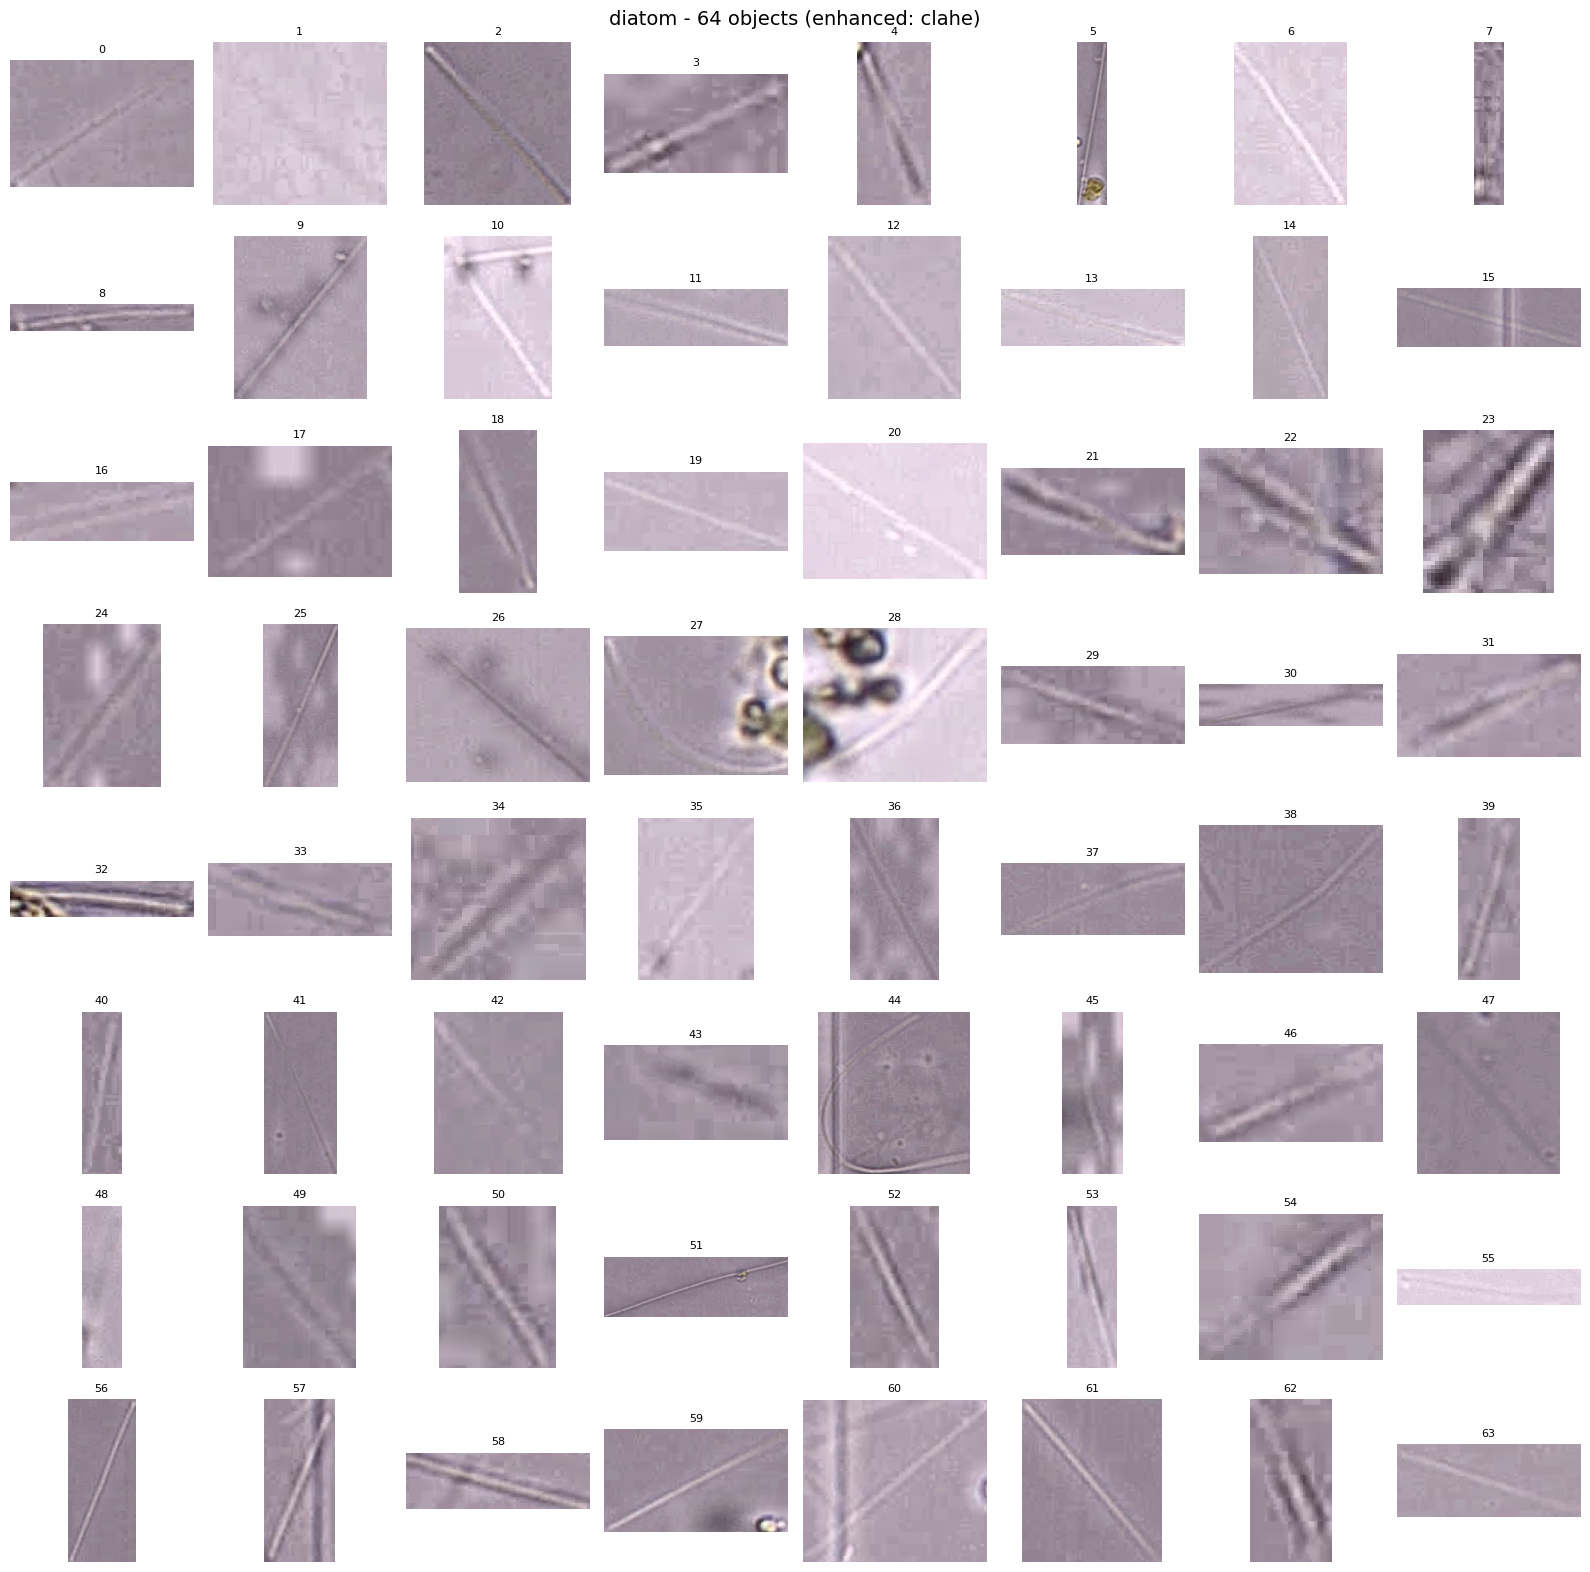

In [31]:


# Updated visualization function with contrast enhancement
def visualize_extracted_objects_enhanced(
  objects: List[np.ndarray],
  class_name: str,
  cols: int = 8,
  max_objects: int = 64,
  enhance_method: str = 'clahe'  # 'clahe', 'histogram_eq', 'gamma', 'linear_stretch', 
'none'
) -> None:
  """Visualize extracted objects with contrast enhancement"""
  objects = objects[:max_objects]
  rows = (len(objects) + cols - 1) // cols

  fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))

  if rows == 1:
      axes = axes.reshape(1, -1)
  if cols == 1:
      axes = axes.reshape(-1, 1)

  for idx, obj in enumerate(objects):
      row, col = idx // cols, idx % cols
      ax = axes[row, col]

      # Enhance contrast
      enhanced = enhance_contrast(obj, method=enhance_method)

      ax.imshow(enhanced)
      ax.set_title(f"{idx}", fontsize=8)
      ax.axis('off')

  # Hide empty subplots
  for idx in range(len(objects), rows * cols):
      row, col = idx // cols, idx % cols
      axes[row, col].axis('off')

  plt.suptitle(f"{class_name} - {len(objects)} objects (enhanced: {enhance_method})",
fontsize=14)
  plt.tight_layout()
  plt.show()

# Usage:
# Try different enhancement methods
visualize_extracted_objects_enhanced(objects, 'diatom', cols=8, enhance_method='clahe')
# visualize_extracted_objects_enhanced(objects, 'diatom', cols=8, enhance_method='histogram_eq')
# visualize_extracted_objects_enhanced(objects, 'Oscillatoria sp', cols=8, enhance_method='gamma')
# visualize_extracted_objects_enhanced(objects, 'diatom', cols=8, enhance_method='linear_stretch')

In [ ]:
def visualize_annotated_images_enhanced(
      image_ids: List[int],
      coco_data: Dict,
      images_dir: str,
      cols: int = 3,
      enhance_method: str = 'clahe'  # 'clahe', 'histogram_eq', 'gamma', 'linear_stretch', 
  'none'
  ) -> None:
      """Visualize multiple annotated images with contrast enhancement"""
      rows = (len(image_ids) + cols - 1) // cols
      fig, axes = plt.subplots(rows, cols, figsize=(100,100))

      if rows == 1:
          axes = axes.reshape(1, -1)
      if cols == 1:
          axes = axes.reshape(-1, 1)

      categories = {cat['id']: cat['name'] for cat in coco_data['categories']}

      for idx, img_id in enumerate(image_ids):
          row, col = idx // cols, idx % cols
          ax = axes[row, col]

          # Get image
          image_info = next((img for img in coco_data['images'] if img['id'] == img_id), None)
          if not image_info:
              ax.axis('off')
              continue

          img_path = f"{images_dir}/{image_info['file_name']}"
          img = cv2.imread(img_path)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

          # Enhance contrast
          img = enhance_contrast(img, method=enhance_method)

          # Get annotations
          annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == img_id]

          # Draw bboxes on enhanced image
          for ann in annotations:
              bbox = ann['bbox']
              x, y, w, h = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
              cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
              label = categories[ann['category_id']]
              cv2.putText(img, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                         0.5, (255, 255, 0), 2)

          ax.imshow(img)
          ax.set_title(f"ID: {img_id}")
          ax.axis('off')

      # Hide empty subplots
      for idx in range(len(image_ids), rows * cols):
          row, col = idx // cols, idx % cols
          axes[row, col].axis('off')

      plt.suptitle(f"Enhanced Annotated Images ({enhance_method})", fontsize=14)
      plt.tight_layout()
      plt.show()

# Usage:
# Visualize with different enhancement methods
visualize_annotated_images_enhanced(image_ids, coco_data, images_dir, cols=3,
enhance_method='clahe')
# visualize_annotated_images_enhanced(image_ids, coco_data, images_dir, cols=3,
# enhance_method='linear_stretch')

In [ ]:
visualize_annotated_images_enhanced(image_ids, coco_data, images_dir, cols=3,
enhance_method='linear_stretch')

In [33]:
objects = extract_objects_by_class('Oscillatoria sp', coco_data, images_dir, max_objects=800)


Using device: cuda
Using CPU UMAP


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


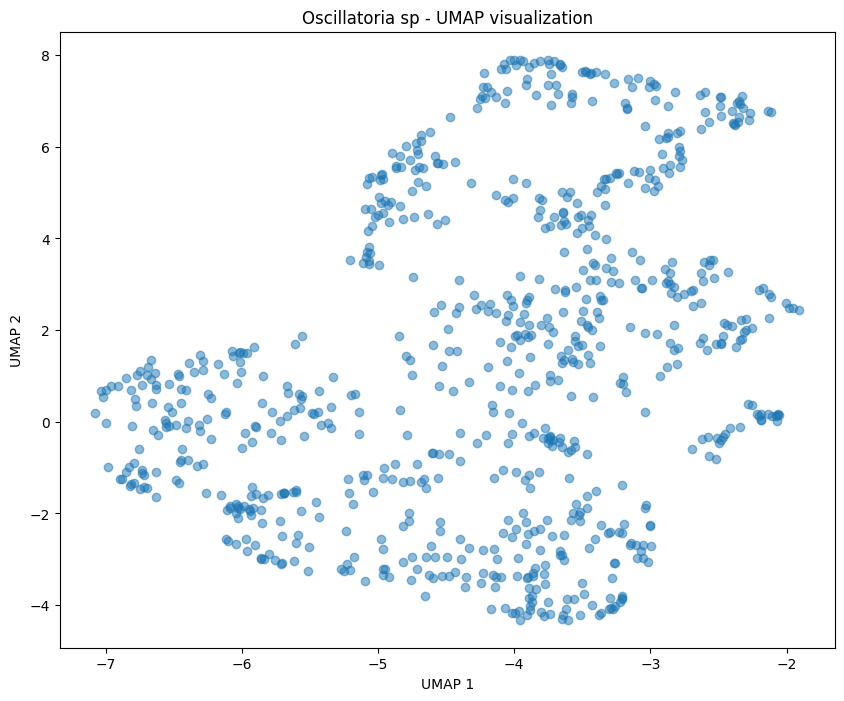

array([[-3.8077118, -2.803373 ],
       [-2.1114767,  2.7221863],
       [-5.7123775, -3.1101804],
       ...,
       [-3.2990084, -2.4022393],
       [-5.905014 , -2.6793976],
       [-5.6568084,  0.632496 ]], dtype=float32)

In [34]:
visualize_with_umap(objects, 'Oscillatoria sp')

Using device: cuda
Using CPU UMAP


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


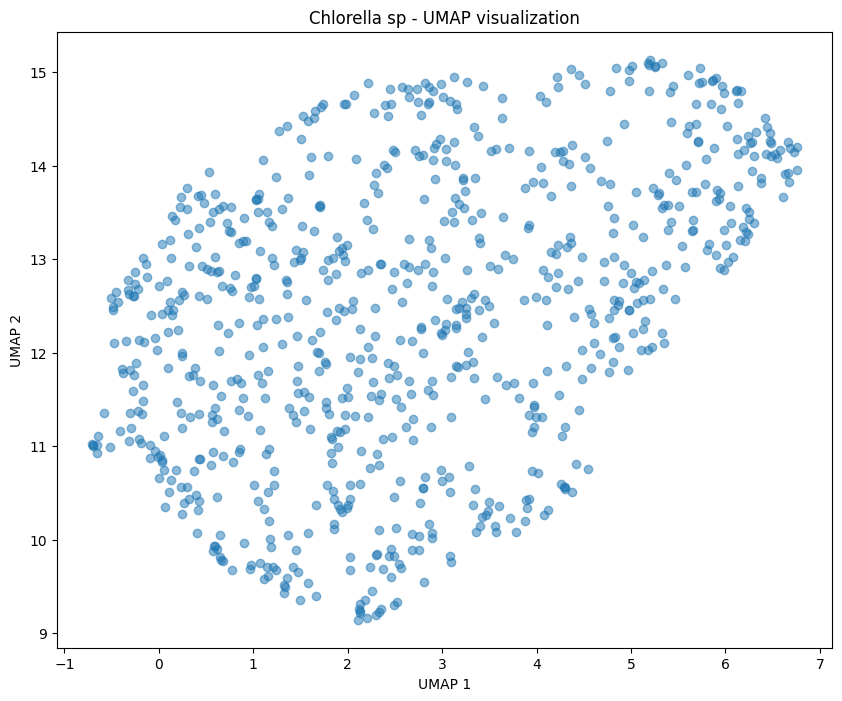

array([[ 0.39913008, 10.072498  ],
       [ 4.0428743 , 13.9844475 ],
       [ 3.0822592 , 10.514682  ],
       ...,
       [ 5.1239605 , 13.243411  ],
       [ 6.221295  , 13.547512  ],
       [ 3.1280153 , 13.402827  ]], dtype=float32)

In [35]:
objects = extract_objects_by_class('Chlorella sp', coco_data, images_dir, max_objects=800)
visualize_with_umap(objects, 'Chlorella sp')

Using device: cuda
Using CPU UMAP


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


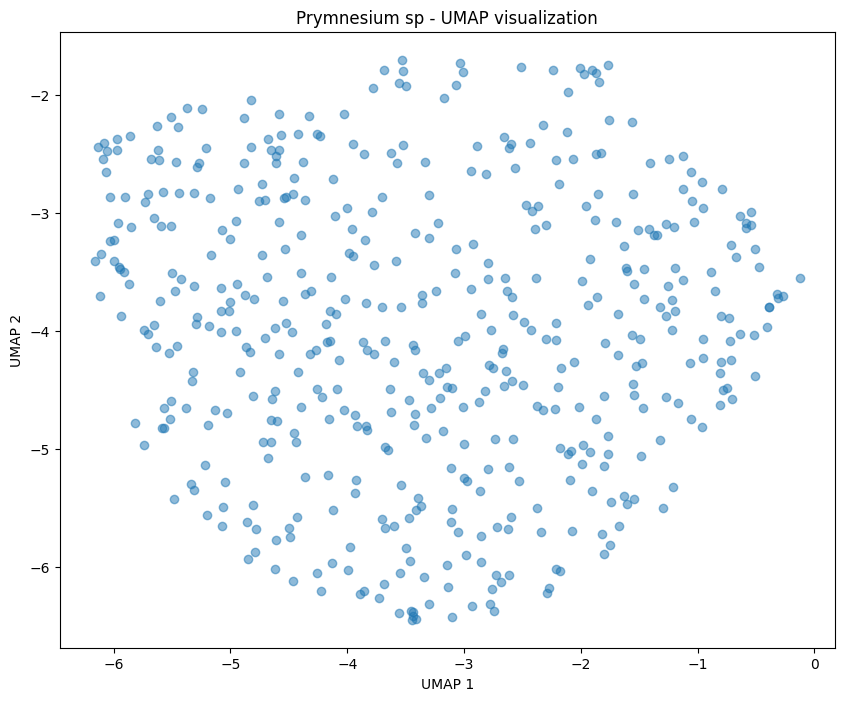

array([[-4.7322984 , -2.759224  ],
       [-4.7057624 , -4.0622563 ],
       [-4.796327  , -3.734109  ],
       [-4.457145  , -4.871619  ],
       [-4.805556  , -4.5548964 ],
       [-0.9564807 , -2.957658  ],
       [-1.817643  , -5.722039  ],
       [-1.6077712 , -5.472601  ],
       [-3.205165  , -4.5716634 ],
       [-4.330488  , -2.1860821 ],
       [-2.3369026 , -5.708678  ],
       [-4.956739  , -4.0074534 ],
       [-4.358769  , -3.6875267 ],
       [-5.9641137 , -3.0910952 ],
       [-2.0958824 , -5.2679515 ],
       [-2.485162  , -3.9254007 ],
       [-1.5473392 , -4.5457544 ],
       [-4.5294404 , -3.3123667 ],
       [-3.1481776 , -4.474351  ],
       [-3.4199452 , -4.7073407 ],
       [-3.458017  , -6.374069  ],
       [-0.5817599 , -3.1288433 ],
       [-5.9452786 , -3.4812863 ],
       [-4.2572193 , -6.05119   ],
       [-2.8540936 , -3.8585863 ],
       [-2.382944  , -3.5520265 ],
       [-4.5409007 , -2.8742757 ],
       [-3.94679   , -3.364292  ],
       [-3.5207722 ,

In [36]:
objects = extract_objects_by_class('Prymnesium sp', coco_data, images_dir, max_objects=800)
visualize_with_umap(objects, 'Prymnesium sp')

Using device: cuda
Extracting Chlorella sp...
  Got 100 samples for Chlorella sp
Extracting Oscillatoria sp...
  Got 100 samples for Oscillatoria sp
Extracting Prymnesium sp...
  Got 100 samples for Prymnesium sp

Total samples: 300
Extracting features...
Running UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


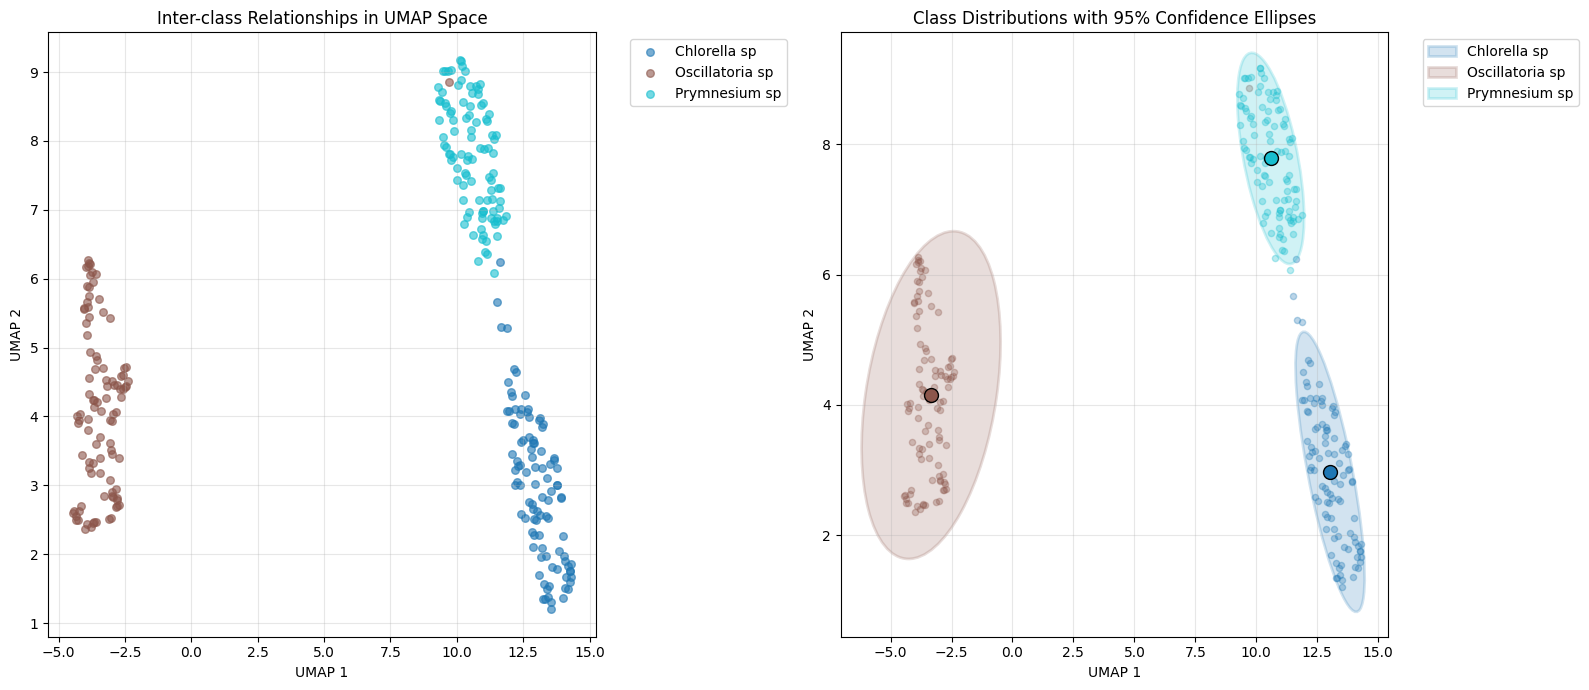


Inter-class distances (centroid-based):
  Chlorella sp <-> Oscillatoria sp: 16.408
  Chlorella sp <-> Prymnesium sp: 5.393
  Oscillatoria sp <-> Prymnesium sp: 14.397

Class separation metrics:
  Silhouette Score: 0.765


In [37]:
def visualize_interclass_variance_umap(
      class_names: List[str],
      coco_data: Dict,
      images_dir: str,
      n_samples_per_class: int = 100,
      target_size: Tuple[int, int] = (64, 64),
      device: str = 'cuda',
      save_path: Optional[str] = None
  ):
      """Visualize multiple classes together in UMAP to see inter-class relationships"""
      from torchvision.models import resnet50, ResNet50_Weights
      import torchvision.transforms as transforms
      import umap

      # Check device
      device = torch.device(device if torch.cuda.is_available() else 'cpu')
      print(f"Using device: {device}")

      # Collect samples from each class
      all_images = []
      all_labels = []
      class_to_idx = {name: idx for idx, name in enumerate(class_names)}

      for class_name in class_names:
          print(f"Extracting {class_name}...")
          objects = extract_objects_by_class(
              class_name, coco_data, images_dir,
              max_objects=n_samples_per_class
          )

          # Resize to consistent size
          resized_objects = [cv2.resize(obj, target_size) for obj in
  objects[:n_samples_per_class]]

          all_images.extend(resized_objects)
          all_labels.extend([class_to_idx[class_name]] * len(resized_objects))

          print(f"  Got {len(resized_objects)} samples for {class_name}")

      print(f"\nTotal samples: {len(all_images)}")

      # Extract features using ResNet
      print("Extracting features...")
      model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
      model.eval()
      feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
      feature_extractor = feature_extractor.to(device)

      transform = transforms.Compose([
          transforms.ToPILImage(),
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

      # Batch processing
      batch_size = 32
      features = []

      with torch.no_grad():
          for i in range(0, len(all_images), batch_size):
              batch_images = all_images[i:i+batch_size]
              batch_tensors = torch.stack([transform(img) for img in batch_images])
              batch_tensors = batch_tensors.to(device)

              batch_features = feature_extractor(batch_tensors)
              batch_features = batch_features.squeeze().cpu().numpy()

              if len(batch_features.shape) == 1:
                  batch_features = batch_features.reshape(1, -1)

              features.append(batch_features)

      features = np.vstack(features)

      # Apply UMAP
      print("Running UMAP...")
      reducer = umap.UMAP(
          n_neighbors=15,
          min_dist=0.1,
          n_components=2,
          random_state=42,
          metric='cosine'  # Good for high-dimensional features
      )
      embedding = reducer.fit_transform(features)

      # Create visualization
      fig, axes = plt.subplots(1, 2, figsize=(16, 7))

      # Plot 1: Colored by class
      ax = axes[0]
      colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))

      for idx, class_name in enumerate(class_names):
          mask = np.array(all_labels) == idx
          ax.scatter(
              embedding[mask, 0],
              embedding[mask, 1],
              c=[colors[idx]],
              label=class_name,
              alpha=0.6,
              s=30
          )

      ax.set_xlabel('UMAP 1')
      ax.set_ylabel('UMAP 2')
      ax.set_title('Inter-class Relationships in UMAP Space')
      ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
      ax.grid(True, alpha=0.3)

      # Plot 2: Density/overlap visualization
      ax = axes[1]
      from matplotlib.patches import Ellipse
      from scipy.stats import multivariate_normal

      for idx, class_name in enumerate(class_names):
          mask = np.array(all_labels) == idx
          class_embedding = embedding[mask]

          # Plot points
          ax.scatter(
              class_embedding[:, 0],
              class_embedding[:, 1],
              c=[colors[idx]],
              alpha=0.3,
              s=20
          )

          # Add confidence ellipse
          if len(class_embedding) > 2:
              mean = np.mean(class_embedding, axis=0)
              cov = np.cov(class_embedding.T)

              # Calculate ellipse parameters
              eigenvalues, eigenvectors = np.linalg.eig(cov)
              angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
              width, height = 2 * np.sqrt(eigenvalues) * 2  # 95% confidence

              ellipse = Ellipse(
                  mean, width, height,
                  angle=angle,
                  facecolor=colors[idx],
                  alpha=0.2,
                  edgecolor=colors[idx],
                  linewidth=2,
                  label=class_name
              )
              ax.add_patch(ellipse)

              # Add class center
              ax.plot(mean[0], mean[1], 'o', color=colors[idx], markersize=10,
                     markeredgecolor='black', markeredgewidth=1)

      ax.set_xlabel('UMAP 1')
      ax.set_ylabel('UMAP 2')
      ax.set_title('Class Distributions with 95% Confidence Ellipses')
      ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
      ax.grid(True, alpha=0.3)

      plt.tight_layout()
      if save_path:
          plt.savefig(save_path, dpi=150, bbox_inches='tight')
      plt.show()

      # Calculate inter-class distances
      print("\nInter-class distances (centroid-based):")
      centroids = {}
      for idx, class_name in enumerate(class_names):
          mask = np.array(all_labels) == idx
          centroids[class_name] = np.mean(embedding[mask], axis=0)

      for i, class1 in enumerate(class_names):
          for class2 in class_names[i+1:]:
              dist = np.linalg.norm(centroids[class1] - centroids[class2])
              print(f"  {class1} <-> {class2}: {dist:.3f}")

      # Calculate overlap metrics
      print("\nClass separation metrics:")
      from sklearn.metrics import silhouette_score
      silhouette = silhouette_score(embedding, all_labels)
      print(f"  Silhouette Score: {silhouette:.3f}")

      return {
          'embedding': embedding,
          'labels': all_labels,
          'class_names': class_names,
          'features': features,
          'centroids': centroids
      }

  # Usage
class_names = ['Chlorella sp', 'Oscillatoria sp', 'Prymnesium sp']  # Replace with your classes
result = visualize_interclass_variance_umap(
  class_names,
  coco_data,
  images_dir,
  n_samples_per_class=100,
  save_path='data_audit/interclass_umap.png'
)